In [1]:
## The usual imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
## for printing image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(torch.__version__)

1.1.0.post2


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu") 

In [4]:
torch.cuda.is_available() 

False

In [5]:
## parameter denoting the batch size 
BATCH_SIZE = 32 
## transformations Compose 将多个transform 放在参数的list中
transform = transforms.Compose([transforms.ToTensor()]) 
## download and load training dataset 
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
# data loader 本身只是一个lodaer 记录了一些 数据的batch_size 以及是否shuffle等信息 以及关联的数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 
## download and load testing dataset 
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
type(trainset)
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [7]:
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))

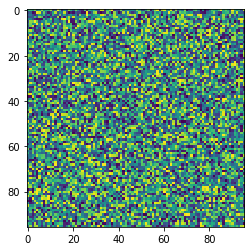

In [8]:
plt.imshow(image)

In [9]:
type(testset)

torchvision.datasets.mnist.MNIST

In [10]:
type(testloader)

torch.utils.data.dataloader.DataLoader

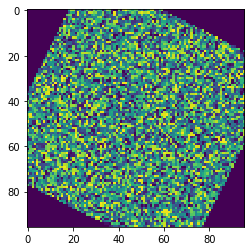

In [11]:
## dummy transformation    
dummy_transform = transforms.Compose( 
 [transforms.RandomRotation(45)]) 
dummy_result = dummy_transform(image) 
plt.imshow(dummy_result)

In [12]:
print(testset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


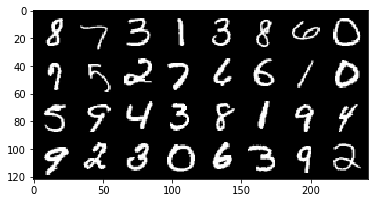

In [13]:
## functionstoshowanimage
def imshow(img): 
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    ## getsomerandomtrainingimages
dataiter = iter(trainloader) 
images, labels = dataiter.next() 
## showimages
imshow(torchvision.utils.make_grid(images))

In [14]:
# train loader 实际上是一个包装好的迭代器
# torch.Size([32, 1, 28, 28])
for images, labels in trainloader: 
    print("Image batch dimensions:", images.shape) 
    print("Image label dimensions:", labels.shape) 
    print(labels)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([8, 1, 8, 4, 8, 0, 3, 9, 7, 9, 1, 7, 7, 5, 0, 8, 9, 6, 3, 7, 3, 9, 2, 4,
        9, 6, 5, 6, 9, 9, 6, 6])


#### 继承nn.Module 模块定义一个神经网络的前馈结构

In [15]:
## the model 
class MyModel(nn.Module): 
    def __init__(self): 
        # 在init中定义 各层对象结构
        super(MyModel, self).__init__() 
        # 就是一般的全连接层 第一个参数是输入维度 第二个参数是输出维度
        # 层对象应该就是一个有了部分参数的偏函数 最后的一个参数就是数据 
        self.d1 = nn.Linear(28 * 28, 128) 
        self.dropout = nn.Dropout(p=0.2) 
        self.d2 = nn.Linear(128, 10) 
        
    def forward(self, x): 
        # 使用init中创建的层对象 构建网络的连接关系
        x = x.flatten(start_dim=1) # 把3d(depth,x,y)的图像数据展平为一维的 这里用的就是普通神经网络不是CNN
        x = self.d1(x)  # 全连接层1
        x = F.relu(x)   # relu 激活函数 
        x = self.dropout(x) # drop_out层 以一定概率来连接
        logits = self.d2(x) #dense2 层  
        out = F.softmax(logits, dim=1)  
        return out

#### 开始训练模型

In [16]:
learning_rate = 0.001 
num_epochs = 5 
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu") 
model = MyModel() 
model = model.to(device) # 模型放到CPU 或者GPU上
criterion = nn.CrossEntropyLoss() # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
## utility function to compute accuracy 
# 自己写一个计算准确度的函数
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum() 
    accuracy = 100.0 * corrects/batch_size 
    return accuracy.item()

In [18]:
## train the model 
for epoch in range(num_epochs): 
    train_running_loss = 0.0 
    train_acc = 0.0 
     ## commence training 
    model = model.train() 
     ## training step 
    for i, (images, labels) in enumerate(trainloader): 
        images = images.to(device) 
        labels = labels.to(device) 
         ## forward + backprop + loss 
        predictions = model(images) 
        #print(predictions, predictions.shape)
        #print(labels, labels.shape)
        #break
        loss = criterion(predictions, labels) 
        optimizer.zero_grad()
        loss.backward()
        ## update model params 
        optimizer.step()
        train_running_loss += loss.detach().item() 
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE) 
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch,train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6000 | Train Accuracy: 87.83
Epoch: 1 | Loss: 1.5290 | Train Accuracy: 93.34
Epoch: 2 | Loss: 1.5135 | Train Accuracy: 94.76
Epoch: 3 | Loss: 1.5043 | Train Accuracy: 95.64
Epoch: 4 | Loss: 1.4994 | Train Accuracy: 96.04


In [19]:
test_acc = 0.0 
for i, (images, labels) in enumerate(testloader, 0): 
    images = images.to(device) 
    labels = labels.to(device) 
    outputs = model(images) 
    test_acc+= get_accuracy(outputs, labels, BATCH_SIZE) 
print('TestAccuracy: %.2f' % (test_acc / i))

TestAccuracy: 96.48
